In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
%matplotlib inline

# Data preperation

In [183]:
#read in whole data excluding Linz csv file :
df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcourse_excl_Linz.csv")
#read in only Ulm data csv file:
#df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcurse_Ulm.csv")

/Users/tamo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [184]:
df.head()

,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear
0,2009-10-06 01:00:00,1,636,391943,6/10/2009,6673,0,1,1,0,Münster,215.0,2009
1,2009-10-07 01:00:00,2,636,391943,7/10/2009,6697,0,1,1,0,Münster,196.0,2009
2,2009-10-08 01:00:00,3,636,391943,8/10/2009,6721,0,1,1,0,Münster,235.0,2009
3,2009-10-09 01:00:00,4,636,391943,9/10/2009,6745,0,1,1,0,Münster,250.0,2009
4,2009-10-10 01:00:00,5,636,391943,10/10/2009,6769,0,2,1,0,Münster,288.0,2009


In [185]:
df["Daten_Herkunft"].unique()

array(['Münster', 'Kaiserslautern', 'Ulm', 'Krefeld', 'Schwerte',
       'Hassfurt', 'Celle'], dtype=object)

In [186]:
#Split df to certain location
df = df[df["Daten_Herkunft"]=="Schwerte"]
df["Fall_ge1"].nunique()

56

In [187]:
#exclude fall_ge1 = 143 (outlier)
df = df[df["Fall_ge1"] != 143]

In [188]:
df["Fall_ge1"].nunique()

55

In [189]:
#convert to datetime format and ad new "date" and "hour"-column in datetime format

df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)
df.head()


,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour
133641,2009-05-01 01:00:00,133642,129,ELON003398,1/5/2009,2881,0,1,1,0,Schwerte,102.0,2009,121,1
133642,2009-05-02 01:00:00,133643,129,ELON003398,2/5/2009,2905,0,2,1,0,Schwerte,167.0,2009,122,1
133643,2009-05-03 01:00:00,133644,129,ELON003398,3/5/2009,2929,0,2,1,0,Schwerte,427.0,2009,123,1
133644,2009-05-04 01:00:00,133645,129,ELON003398,4/5/2009,2953,0,1,1,0,Schwerte,78.0,2009,124,1
133645,2009-05-05 01:00:00,133646,129,ELON003398,5/5/2009,2977,0,1,1,0,Schwerte,96.0,2009,125,1


In [190]:
#normalisation:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df['norm_energy'] = df['Electricity_Demand'] / df['max_energy']

In [191]:
#Meteorological seasons:
#winter
sdate_wi = date(2009, 12, 1)   # start date
edate_wi = date(2010, 2, 28)   # end date
#spring
sdate_sp = date(2010, 3, 1)   # start date
edate_sp = date(2010, 5, 31)   # end date
#summer
sdate_su = date(2010, 6, 1)   # start date
edate_su = date(2010, 8, 31)   # end date
#Fall
sdate_fa = date(2009, 9, 1)   # start date
edate_fa = date(2009, 11, 30)   # end date

In [192]:
#filter df by season:
df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [193]:
df_sp.shape

(109440, 17)

In [194]:
df_su.shape

(113160, 17)

In [195]:
df_wi.shape

(106992, 17)

In [196]:
df_fa.shape

(101928, 17)

In [197]:
#split dataframes into weekday and weekend days
df_fa_week=df_fa[df_fa["Weekday"]==1]
df_fa_wknd=df_fa[df_fa["Weekday"]==2]
df_wi_week=df_wi[df_wi["Weekday"]==1]
df_wi_wknd=df_wi[df_wi["Weekday"]==2]
df_sp_week=df_sp[df_sp["Weekday"]==1]
df_sp_wknd=df_sp[df_sp["Weekday"]==2]
df_su_week=df_su[df_su["Weekday"]==1]
df_su_wknd=df_su[df_su["Weekday"]==2]

In [198]:
df.set_index("datetime", inplace = True)

# Functions for clustering

In [199]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

In [200]:
#multiline plot:
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [201]:
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [202]:
#def plot_clustering_results()

In [203]:
#def cluster_overview(cluster_centers)
#    sort
#    plt.plot(fall_week[x],label="Cluster " + str(x + 1))

In [204]:
# for x in range(0,5,1):
#     plt.plot(fall_week[x],label="Cluster " + str(x + 1))
# plt.legend()
# plt.title("Fall weekdays")
# plt.ylabel("normalized consumption")
# plt.xlabel("hour")

# Fall

### Fall weekday 

In [205]:
red_df=df_fa_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
if "cluster" in kmeans_df:
    del kmeans_df["cluster"]

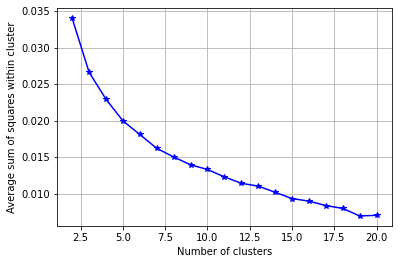

In [206]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [207]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 5 corresponds to the element with index 3
clustering = k_res[3]

In [208]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [209]:
kmeans_df['cluster'] = list(lut[clustering.labels_])
kmeans_df['cluster']

Fall_ge1
82      0
83      0
84      0
87      0
93      3
97      1
98      1
99      1
100     2
102     3
104     4
105     3
109     0
110     2
113     2
115     1
116     2
117     1
118     1
119     2
120     1
121     0
122     3
124     2
125     1
129     1
131     0
132     1
133     3
138     3
139     0
145     3
146     0
147     3
1057    3
1058    3
1059    0
1061    3
1062    2
1063    0
1064    3
1065    0
1067    2
1068    2
1069    1
1070    1
1071    1
1073    3
1074    3
1076    1
1077    0
1078    3
1080    0
Name: cluster, dtype: int64

In [210]:
clust_cent = clustering.cluster_centers_


In [211]:
kmeans_df[kmeans_df["cluster"] == 4]

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
104,0.244747,0.218493,0.211883,0.207341,0.205384,0.209261,0.212252,0.216462,0.235553,0.186256,...,0.196448,0.195229,0.206824,0.233743,0.240833,0.286142,0.291274,0.288099,0.251542,4


Text(0.5, 0, 'hour')

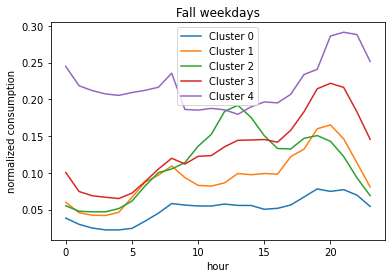

In [212]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

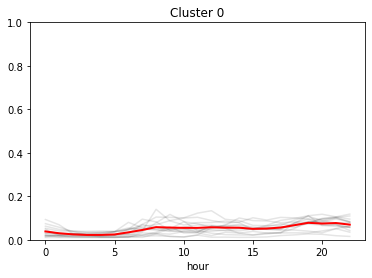

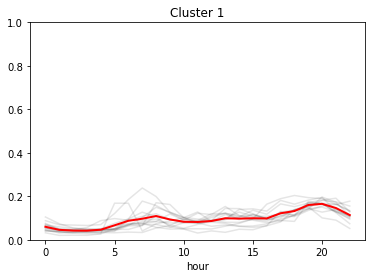

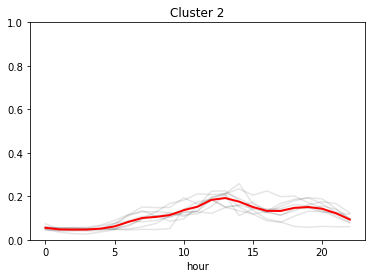

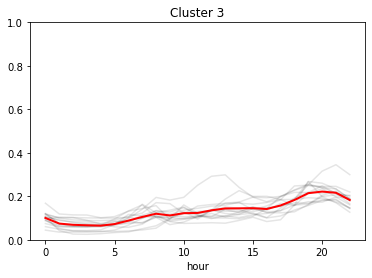

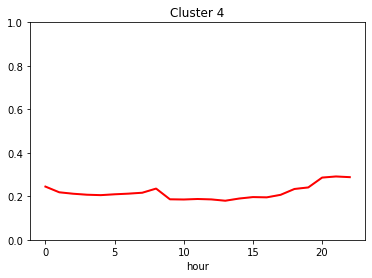

In [213]:
kmeans_df['Fall_ge1'] = kmeans_df.index
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

In [214]:
kmeans_df[kmeans_df["cluster"]==1]

hour,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,cluster,Fall_ge1
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
97,0.065034,0.050837,0.045412,0.044108,0.048367,0.062812,0.075050,0.076528,0.057412,0.049240,...,0.163945,0.189195,0.203898,0.193871,0.189706,0.163241,0.134585,0.083614,1,97
98,0.055278,0.042969,0.047012,0.056510,0.088217,0.097677,0.089682,0.090567,0.095012,0.068103,...,0.132087,0.181189,0.163946,0.182448,0.194779,0.134280,0.105715,0.083913,1,98
99,0.051064,0.048043,0.047228,0.047545,0.050259,0.075709,0.095918,0.178074,0.157559,0.123891,...,0.117546,0.165044,0.152517,0.168787,0.167996,0.164379,0.130786,0.075756,1,99
115,0.046450,0.031382,0.033479,0.038928,0.044394,0.045247,0.069478,0.070518,0.070737,0.056873,...,0.096930,0.126736,0.137602,0.153527,0.167017,0.128345,0.099043,0.068218,1,115
117,0.032181,0.020386,0.021147,0.020620,0.027199,0.050736,0.095743,0.127172,0.105166,0.060339,...,0.065002,0.130489,0.111197,0.167724,0.166523,0.142167,0.105544,0.054349,1,117
118,0.075464,0.049028,0.042402,0.036464,0.033683,0.032374,0.035412,0.033577,0.054266,0.066034,...,0.095923,0.088939,0.084681,0.171303,0.182669,0.191203,0.128616,0.102208,1,118
120,0.104904,0.073887,0.054814,0.047232,0.045437,0.048876,0.065835,0.103103,0.149682,0.126879,...,0.108164,0.119772,0.135759,0.151088,0.181079,0.174841,0.155199,0.132288,1,120
125,0.087942,0.069347,0.067727,0.065898,0.069887,0.121089,0.185445,0.238339,0.199008,0.126888,...,0.086464,0.110891,0.106849,0.134972,0.156124,0.162118,0.177700,0.112309,1,125
129,0.040976,0.036018,0.033651,0.035012,0.039719,0.040713,0.063986,0.065878,0.110244,0.092278,...,0.096035,0.109605,0.135720,0.142578,0.150158,0.129359,0.094887,0.058825,1,129


### Fall weekend 

In [215]:
red_df=df_fa_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

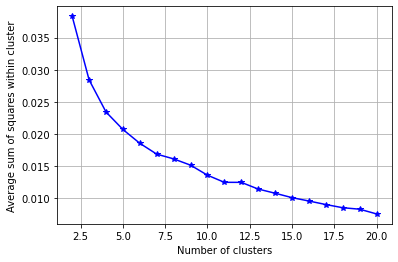

In [216]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [217]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [218]:
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [219]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [220]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

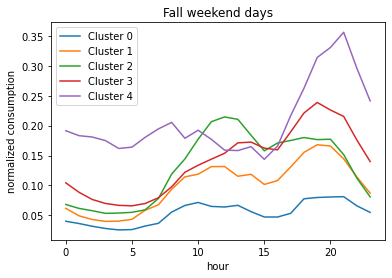

In [221]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

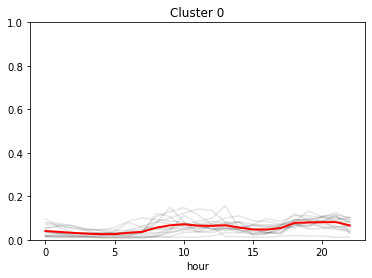

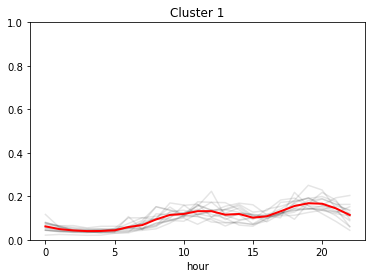

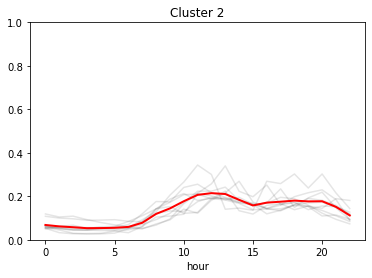

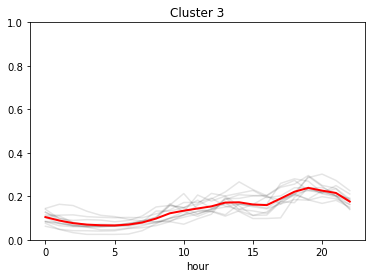

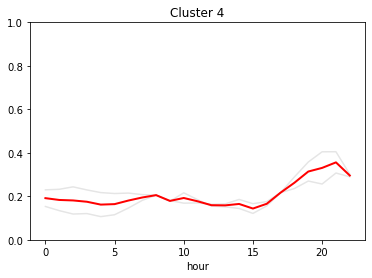

In [222]:
kmeans_df['Fall_ge1'] = kmeans_df.index
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

# Winter

### Winter weekdays

In [223]:
red_df=df_wi_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

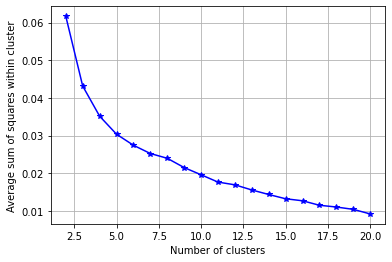

In [224]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [225]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [226]:
k=6
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [227]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [228]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

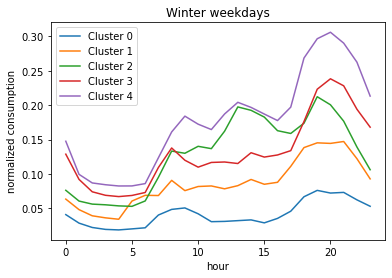

In [229]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

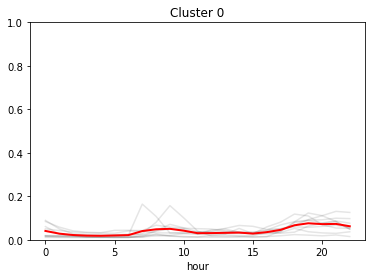

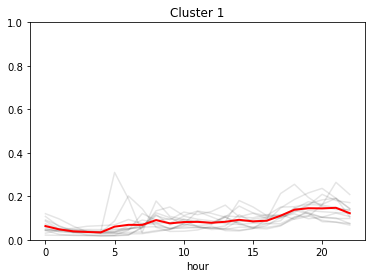

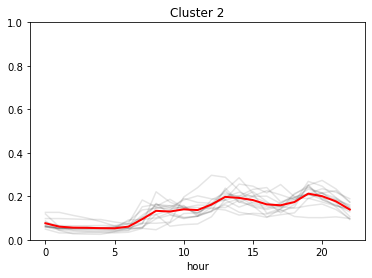

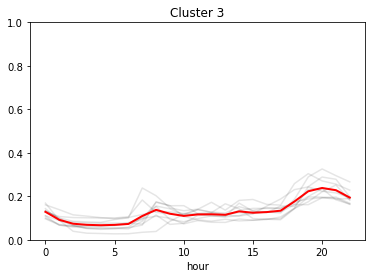

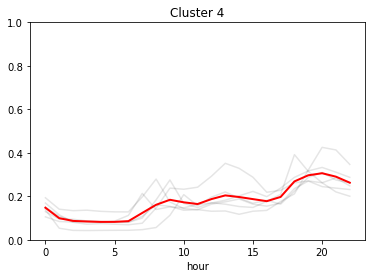

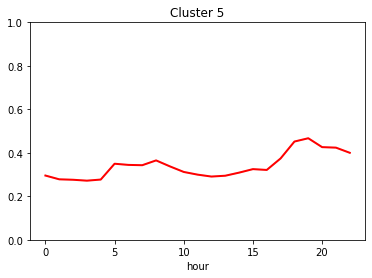

In [230]:
kmeans_df['Fall_ge1'] = kmeans_df.index
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

### Winter weekend days

In [231]:
red_df=df_wi_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

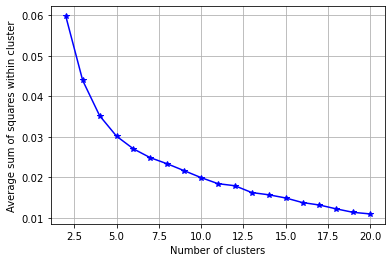

In [232]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [233]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [234]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [235]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [236]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

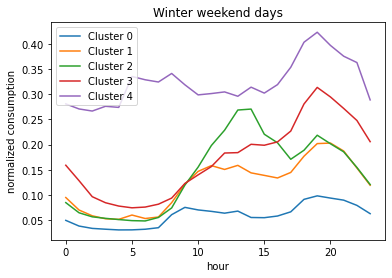

In [237]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Spring

### Spring weekdays

In [238]:
red_df=df_sp_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

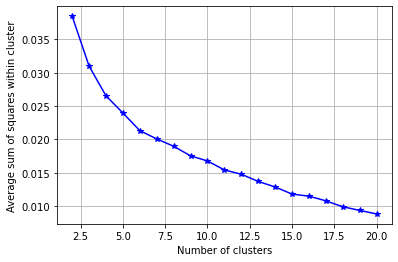

In [239]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [240]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [241]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [242]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [243]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

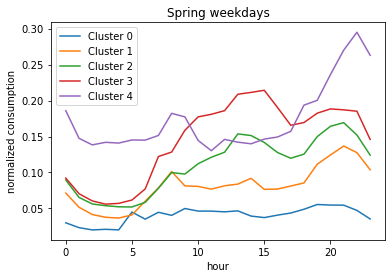

In [244]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Spring weekend days

In [245]:
red_df=df_sp_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

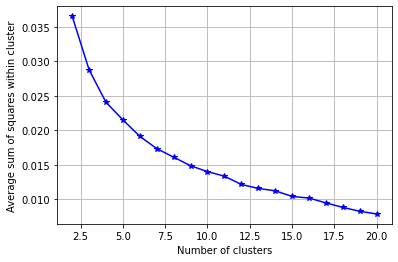

In [246]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [247]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [248]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [249]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [250]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

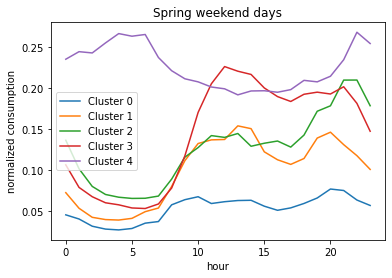

In [251]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Summer

### Summer weekdays

In [252]:
red_df=df_su_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

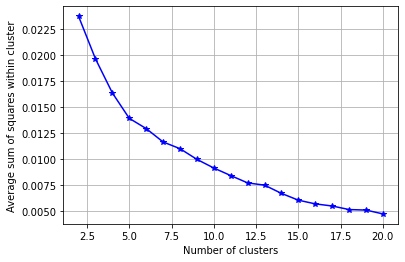

In [253]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [254]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [255]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [256]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [257]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

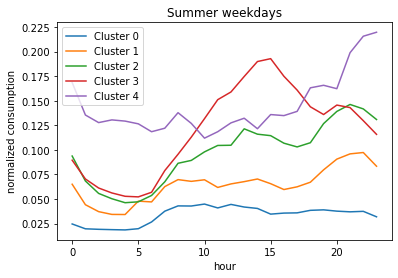

In [258]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Summer weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Summer weekend days

In [259]:
red_df=df_su_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

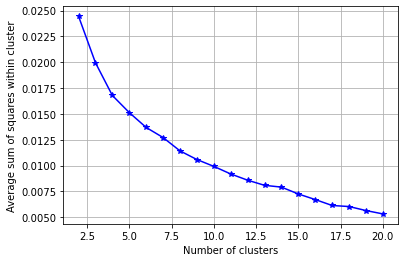

In [260]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [261]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [262]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [263]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [264]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

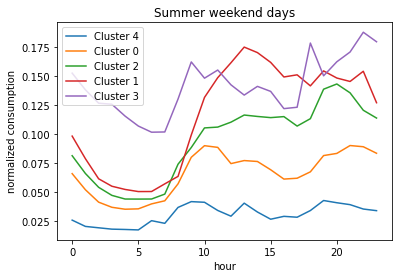

In [265]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(idx[x]))  
plt.legend()
plt.title("Summer weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [266]:
kmeans_df[kmeans_df["cluster"]== 4]

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
102,0.140166,0.103950,0.092872,0.087156,0.072215,0.054404,0.054187,0.073747,0.111129,0.202927,...,0.138005,0.110992,0.089397,0.091912,0.115942,0.163647,0.174095,0.178794,0.135399,4
104,0.182222,0.217778,0.208802,0.216906,0.177865,0.168540,0.164444,0.161394,0.140566,0.136209,...,0.125577,0.115991,0.110153,0.115643,0.117821,0.118170,0.144401,0.180305,0.183791,4
133,0.172840,0.118635,0.098912,0.103222,0.110490,0.097487,0.090365,0.089853,0.146212,0.166667,...,0.162028,0.151728,0.163599,0.393710,0.219118,0.177296,0.215319,0.230879,0.235518,4
147,0.149967,0.133272,0.121257,0.116893,0.114098,0.112229,0.096326,0.078388,0.142324,0.180746,...,0.113239,0.103527,0.109150,0.142933,0.137460,0.184743,0.158886,0.198101,0.217199,4
1061,0.118343,0.118073,0.112033,0.105220,0.103563,0.102777,0.103550,0.106533,0.111677,0.125353,...,0.146002,0.128287,0.144148,0.149120,0.161703,0.168713,0.161961,0.151845,0.126986,4


# Additional methods 

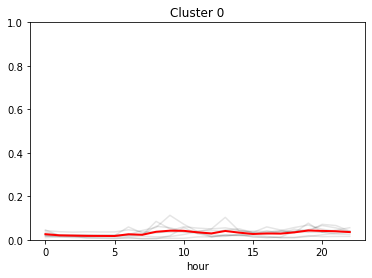

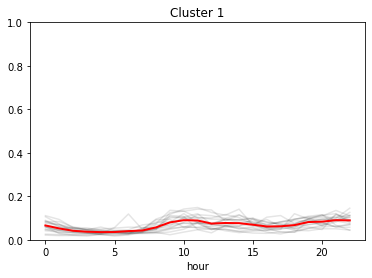

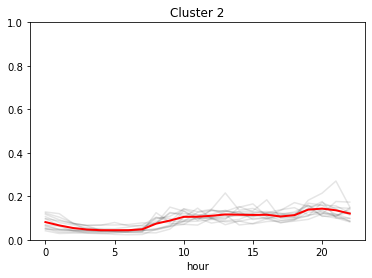

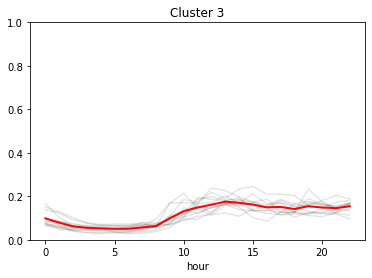

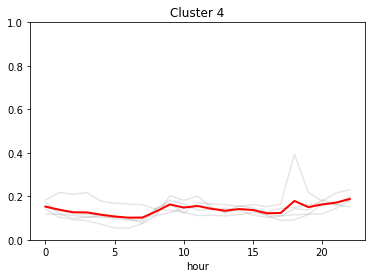

In [267]:
kmeans_df['Fall_ge1'] = kmeans_df.index
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

## Closer look at a cluster

In [268]:
# cl4_df = kmeans_df[kmeans_df["cluster"]==4]

In [269]:
# cl4_lst = list(cl4_df["Fall_ge1"].unique())
# cl4_lst

In [270]:
# df[df["Fall_ge1"].isin(cl4_lst)].loc["2010-05-02"].groupby("Fall_ge1").Electricity_Demand.plot()

In [271]:
# cl6_df = df[df["Fall_ge1"].isin(cl6_lst)]
# cl6_df["Daten_Herkunft"].unique()